# Predicting Restaurant Inspection Grades with Machine Learning

**Background:** Restaurant inspections are a vital service provided by cities to ensure that residents are protected from food-borne illnesses and other hazards. Unfortunately for New York City, conducting restaurant inspections at scale is as logistically complex as it is expensive - it costs over $16.5 million to inspect the city's 25,000+ restaurants annually. If the City could predict which restaurants were likely to receive low grades, they could allocate resources more efficiently toward improving public health while decreasing operating costs and helping restaurants remain in business.  

More information on the inspection process: https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

**Question:** Can New York City's Department of Health and Mental Hygiene (DOHMH) optimize their restaurant inspection process by predicting which establishments are likely to receive low grades? 

**Results:** Using a Random Forest Classifier we are able to predict which restaurants will receive low grades on inspections at a rate 3x better than chance. At that level of precision, the City could identify about 70% of restaurants that might pose health & safety risks to customers and prioritize them for future inspections, outreach, oversight, assistance, or other interventions. 

## PART 0: Importing the Data

**Data Source:** https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

**Description:** "The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias [...] Only restaurants in an active ['Not out of business'] status are included in the dataset. Records are also included for each restaurant that has applied for a permit but has not yet been inspected and for inspections resulting in no violations." 

In [345]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read in data from NYC open data portal
# df_raw = pd.read_csv('https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD')

## PART 1: Data Cleaning

We start by undertaking the following steps to clean the data:

1. Rename columns and remove those which are unlikely to be useful
2. Round latitude and longitude to 2 decimals to use as a feature
3. Remove 23 records where borough is not recorded
4. Convert date columns to datetime
5. Drop 5539 restaurant who've never received an A, B, or C letter grade, since we're only interested in predicting letter grades. Generally these restaurants have pending or provisional grades
6. Narrow down to a subset of INSPECTION TYPE including: 1) "Cycle Inspection / Re-inspection", 2) "Pre-permit (Operational) / Re-inspection", 3) "Pre-permit (Operational) / Initial Inspection", and 4) "Cycle Inspection / Reopening Inspection". In total, there are 32 inspection types, but only 15 give letter grades. Of those 15, only 6 give ABC grades. Only 2, (1 & 2 above) give a full distribution of A's B's and C's. We include 3 & 4 from the above list because initial inspection grades and reopening inspections (i.e. after a mandated shutdown) may be predictive of later grades
7. Remove the latest inspection grade for each restaurant. This will be used as the target variable. All previous inspections will be used as features

In [346]:
# 1. Rename columns and remove unnecessary ones

# Rename cols
df_raw.rename(
    columns= {
        'CAMIS':'ID',
        'DBA':'NAME',
        'ZIPCODE':'ZIP',
        'CUISINE DESCRIPTION':'CUISINE',
        'Latitude':'LAT',
        'Longitude':'LON'
    },
    inplace=True
)

# Drop useless columns
# df_raw.drop(['BUILDING', 'PHONE', 'RECORD DATE', 'BIN', 'BBL'], axis=1, inplace=True)

# 2. Round off LAT/LON to use as feature
df_raw['LAT'] = df_raw['LAT'].round(2)
df_raw['LON'] = df_raw['LON'].round(2)

# 3. Drop records where boro = 0
df_raw = df_raw[df_raw['BORO'] != '0']

# 4. Convert date columns to datetime
df_raw[['INSPECTION DATE','GRADE DATE']] = df_raw[['INSPECTION DATE','GRADE DATE']].apply(pd.to_datetime)

# 5. Get rid of restaurants that have never received a letter grade
graded = df_raw[df_raw['GRADE'].isin(['A','B','C'])]['ID'].drop_duplicates()
df_raw[df_raw['ID'].isin(graded)]

# # Only look at re-inspections
# df_raw = df_raw.query('`INSPECTION TYPE` == "Cycle Inspection / Re-inspection" ')

# 6. Keep 4 inspection types that give letter grades or are useful predictors
inspection_type_keep = [
    'Pre-permit (Operational) / Re-inspection', 
    "Cycle Inspection / Re-inspection", 
    'Cycle Inspection / Reopening Inspection', 
    'Pre-permit (Operational) / Initial Inspection'
    ]
df_raw = df_raw[df_raw['INSPECTION TYPE'].isin(inspection_type_keep)]

# 7. Split latest review from all previous reviews. Lateset will be target variable

# Get max version mv (but only where the inspection type is re-inspection)
mv = pd.merge(df_raw[['ID', 'GRADE DATE']], df_raw[(df_raw['GRADE'].isin(['A','B','C'])) & (df_raw['INSPECTION TYPE'].isin(inspection_type_keep[0:2]))].groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID', 'GRADE DATE']).rename(columns={'GRADE DATE':'mv'}).drop_duplicates()

# Self join df_raw to max version to create column with max grade date
df_raw = pd.merge(df_raw, mv, how='left', on='ID', suffixes=['','_mv'])

# Latest review is when grade date == mv. Otherwise it's a previous review
df_latest_review = df_raw.query('`GRADE DATE` == mv')[['ID','GRADE','mv']].drop_duplicates()
df_prev_reviews = df_raw.query('`GRADE DATE` != mv').drop_duplicates()

## PART 2: Feature engineering

In this section we create features from the existing data and collapse the dataset down to 1 row per restaurant. Each of the new features is described below:
* **n_inspections:** The number of distinct inspections each restaurant has gone through prior to their latest one
* **avg_scores:** Scores are generated based on the number and severity of violations on each inspection. Here we take the average scores from across a restaurant's previous inspections
* **n_violations:** The total number of violations from all previous inspections
* **no_violation_inspection:** The number of times a restaurant has had an inspection without any violations
* **closed_by_DOHMH:** The number of times a restaurant has been closed by the department as a result of an inspection
* **reopened:** The number of times a restaurant has been reopened after a forced closure
* **n_critical:** The number of critical violations from all previous inspections
* **n_a_grade:** The number of A grades received in the past (multiplied by 100 and divided by n_inspections) 
* **n_b_grade:** The number of B grades received in the past (multiplied by 100 and divided by n_inspections)
* **n_c_grade:** The number of C grades received in the past (multiplied by 100 and divided by n_inspections)
* **first_grade:** The earliest recorded A/B/C grade for each restaurant
* **penult_grade:** The penultimate grade before the latest grade used as the target variable (100 if A else 0)
* **105 dummy variables** - 1 for each violation type with values of the number of times each restaurant has committed each violation
* **violations_per_inspection:** The number of violations per inspection per restaurant
* **critical_violations_per_inspection:** The number of critical violations per inspection per restaurant
* **CATEGORY:** The 82 restaurant types are collapsed into fewer categories 
* **STREET_BORO:** A combination of street name and borough
* **CATEGORY BORO:** a combination of category and borough
* **CATEGORY STREET BORO:** a combination of category, street name, and borough
* **CUISINE STREET BORO:** a combination of cuisine, street name, and borough
* **CATEGORY CENSUS TRACT:** a combination of category and census tract
* **CUISINE CENSUS TRACT:** a combination of cuisine and census tract
* **CUISINE BORO:** a combination of cuisine and borough


In [347]:
# Create features
n_inspections = df_prev_reviews.groupby('ID')['INSPECTION DATE'].nunique().rename('n_inspections')
avg_scores = df_prev_reviews.groupby(['ID', 'INSPECTION DATE'])['SCORE'].mean().reset_index().groupby('ID')['SCORE'].mean().rename('avg_score')
n_violations = df_prev_reviews.query('ACTION == "Violations were cited in the following area(s)."').groupby('ID')['ACTION'].count().rename('n_violations')
no_violation_inspection = df_prev_reviews.query('ACTION == "No violations were recorded at the time of this inspection."').groupby('ID')['ACTION'].count().rename('clean_inspections')
closed_by_DOHMH = df_prev_reviews.query('ACTION == "Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed."').groupby('ID')['ACTION'].count().rename('shutdowns')
reopened = df_prev_reviews.query('ACTION == "Establishment re-opened by DOHMH."').groupby('ID')['ACTION'].count().rename('reopened_count')
n_critical = df_prev_reviews.query('`CRITICAL FLAG` == "Critical" ').groupby('ID')['CRITICAL FLAG'].count().rename('n_critical_violations')
n_a_grade = df_prev_reviews.query('`GRADE` == "A" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_A_grades')
n_b_grade = df_prev_reviews.query('`GRADE` == "B" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_B_grades')
n_c_grade = df_prev_reviews.query('`GRADE` == "C" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_C_grades')
first_grade = df_prev_reviews.merge(df_prev_reviews[df_prev_reviews['GRADE'].isin(['A','B','C'])].groupby('ID')['GRADE DATE'].min().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('first_grade')
# penult_grade = pd.merge(df_prev_reviews, df_prev_reviews.groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('penult_grade')
penult_grade = pd.merge(df_prev_reviews, df_prev_reviews.groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].dropna().groupby('ID')['GRADE'].min().rename('penult_grade')
# critical_violations_latest =
# critical_violations_first = 

# This will be target variable
latest_grade = df_latest_review.groupby('ID')['GRADE'].max().rename('latest_grade')

# Create dummy features for violation types
dummies = pd.get_dummies(df_prev_reviews[['ID', 'VIOLATION CODE']])
dummy_sums = dummies.groupby('ID')[list(dummies.columns[1:])].sum()

# Aggregate to each restaurant by merging categorical features with engineered features 
cat = df_raw[['ID','BORO','STREET','ZIP','CUISINE','LAT','LON','Community Board','Council District','Census Tract','NTA']].drop_duplicates()
# Merge features on ID
merged = pd.merge(cat, n_inspections, on='ID', how='left')\
    .merge(avg_scores, on='ID', how='left')\
    .merge(n_violations, on='ID', how='left')\
    .merge(no_violation_inspection, on='ID', how='left')\
    .merge(reopened, on='ID', how='left')\
    .merge(n_critical, on='ID', how='left')\
    .merge(n_a_grade, on='ID', how='left')\
    .merge(n_b_grade, on='ID', how='left')\
    .merge(n_c_grade, on='ID', how='left')\
    .merge(latest_grade, on='ID', how='left')\
    .merge(first_grade, on='ID', how='left')\
    .merge(closed_by_DOHMH, on='ID', how='left')\
    .merge(penult_grade, on='ID', how='left')\
    .merge(dummy_sums, on='ID',how='left')

# Create the rest of the features
merged['violations_per_inspection'] = merged['n_violations'] / merged['n_inspections']
merged['critical_violations_per_inspection'] = merged['n_critical_violations'] / merged['n_inspections']

# Collapse cuisine into fewer categories
cuisine_category = {
    'Caribbean':'Other', 
    'Hamburgers':'Fast', 
    'Chinese':'East Asian', 
    'Pizza':'Fast', 
    'Italian':'South European', 
    'Polish':'Eastern European',       
    'Japanese':'East Asian', 
    'Donuts':'Dessert', 
    'Chicken':'Fast', 
    'Spanish':'South European', 
    'Coffee/Tea':'Cafe', 
    'Indian':'South Asian',
    'American':'American', 
    'African':'African', 
    'Salads':'Healthy', 
    'Southeast Asian':'SE Asian', 
    'Korean':'East Asian',       
    'Latin American':'LATAM', 
    'Australian':'Other', 
    'Bakery Products/Desserts':'Dessert',
    'Mexican':'LATAM', 
    'Sandwiches':'Deli', 
    'Turkish':'Middle Eastern', 
    'Thai':'SE Asian', 
    'Tex-Mex':'LATAM', 
    'Ethiopian':'African',
    'Vegan':'Healthy', 
    'Irish':'Western European', 
    'Asian/Asian Fusion':'East Asian', 
    'Greek':'South European', 
    'Seafood':'Seafood',
    'Juice, Smoothies, Fruit Salads':'Healthy', 
    'Bagels/Pretzels':'Bakery',
    'Jewish/Kosher':'Deli', 
    'Frozen Desserts':'Dessert',
    'Sandwiches/Salads/Mixed Buffet':'Deli', 
    'Steakhouse':'Steakhouse', 
    'Mediterranean':'South European',
    'French':'Western European', 
    'Russian':'Eastern European', 
    'Peruvian':'LATAM', 
    'Vegetarian':'Healthy', 
    'Barbecue':'American',
    'Eastern European':'Eastern European', 
    'Bottled Beverages':'Other', 
    'Bangladeshi':'South Asian',
    'Middle Eastern':'Middle Eastern', 
    'Soups/Salads/Sandwiches':'Deli', 
    'Filipino':'SE Asian', 
    'Tapas':'South European',
    'Pakistani':'South Asian', 
    'Brazilian':'LATAM', 
    'Creole':'Other', 
    'Creole/Cajun':'Other', 
    'German':'Western European',
    'Moroccan':'Middle Eastern', 
    'Hotdogs':'Fast', 
    'Other':'Other', 
    'Soul Food':'American', 
    'Chinese/Cuban':'Other',
    'Continental':'Western European', 
    'Chinese/Japanese':'East Asian', 
    'Iranian':'Middle Eastern', 
    'Hotdogs/Pretzels':'Street',
    'Hawaiian':'Other', 
    'English':'Western European', 
    'Soups':'Deli', 
    'Afghan':'Middle Eastern', 
    'Californian':'American',
    'Pancakes/Waffles':'Breakfast', 
    'Scandinavian':'Northern European', 
    'Egyptian':'Middle Eastern', 
    'Southwestern':'LATAM',
    'Portuguese':'South European', 
    'Chilean':'LATAM', 
    'Fruits/Vegetables':'Healthy', 
    'Cajun':'Other',
    'Indonesian':'SE Asian', 
    'Not Listed/Not Applicable':'NA', 
    'Nuts/Confectionary':'Street',
    'New American':'American'
}
merged = pd.merge(merged, pd.DataFrame(cuisine_category.items(), columns=['CUISINE','CATEGORY']), on=['CUISINE'])

# Continue feature engineering
merged['STREET_BORO'] = merged['STREET'].astype('str') + merged['BORO'].astype('str')
merged['penult_grade'] = [100 if x == 'A' else 0 for x in merged['penult_grade']]
merged['n_A_grades'] = (100 * merged['n_A_grades']) / merged['n_inspections']
merged['n_B_grades'] = (100 * merged['n_B_grades']) / merged['n_inspections']
merged['n_C_grades'] = (100 * merged['n_C_grades']) / merged['n_inspections']
merged['CATEGORY BORO'] = merged['CATEGORY'] + merged['BORO']
merged['CATEGORY STREET BORO'] = merged['CATEGORY'].astype('str') + merged['STREET_BORO'].astype('str')
merged['CATEGORY CENSUS TRACT'] = merged['CATEGORY'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE BORO'] = merged['CUISINE'].astype('str') + merged['BORO'].astype('str')
merged['CUISINE CENSUS TRACT'] = merged['CUISINE'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE STREET BORO'] = merged['CUISINE'].astype('str') + merged['STREET_BORO'].astype('str')


# CREATE TARGET VARIABLE
merged = merged[merged['latest_grade'].isin(['A','B','C'])]
merged['latest_grade'] = ['A' if x == 'A' else 'B or C' for x in merged['latest_grade']]
# Create score for latest grade to use in target encoding
merged['latest_grade_score'] = [100 if x == 'A' else 0 for x in merged['latest_grade']]

# Fill na, get rid of restaurants with no previous inspections
merged = merged.fillna(0)
merged = merged[merged['n_inspections'] > 0].drop_duplicates()

## PART 3: Predicting Inspection Grades

**Model Selection:** We choose a Random Forest Classifier for two reasons: First, the predictors are complicated in their datatypes, scales, and variety (e.g. many categorical features have nearly 100 levels, some are text, some are numerical, etc.). Using a Random Forest reduces pre-processing such as standardization and dimension reduction. Second, interpretability is important to ensure our model isn't making predictions on any objectionable criteria. Seeing as the model is intended to help a city department make decisions, it's important to have an understanding of how it works.

**Dealing with Imbalanced Classes:** In Part 3a below, we fit a Random Forest Classifier to the training data as-is. Later, in Part 3b, we fit a new model to class-balanced training data using SMOTE (synthetic minority oversampling technique). The class imbalance between A's and lower grades in 3a results in low recall on the minority class - we try to solve this to ensure the model points DOHMH inspectors towards more restaurants that are likely to receive low grades. Our SMOTE model improves recall significantly for a small tradeoff in precision.   

**Note on Target Variable:** Our target variable is bucketed into "A" and "B or C." Previous instantiations of the model showed poor results when predicting A's, B's, and C's separately in a multi-class classification. This is likely explained by 2 issues: 1) there's a large class imbalance, with 77% of grades being A, and B and C comprising 17% and 6% respectively, and 2) the model struggles to differentiate B's and C's from each other. When all 3 grades are present as options for the model to choose, the probabilities on which it bases its class assignment are diluted across B and C, making A a comparatively surer bet. When B's and C's are bucketed, the model can have higher confidence in correctly classifying an observation as not A. 

### PART 3a: Random Forest without SMOTE

**Preprocessing:** Categorical variables undergo Target Encoding using the latest_grade_score variable, which is set to 100 for an A and 0 for a B or C. This quantifies each categorical variable in relation to the target variable, which yields better predictions given the fact that categorical variables have up to ~100 levels.

**Hyperparameter Tuning:** We honed in on the optimal range for hyperparameters using RandomizedSearchCV. Further fine-tuning improved results marginally from there.

In [348]:
# Import ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

# Use Target Encoding on categorical features using latest_grade_score
for col in list(merged.drop(['ID','latest_grade'], axis=1).columns):
    te = ce.TargetEncoder(cols=[col])
    te.fit(merged[col], merged['latest_grade_score'])
    merged[col] = te.transform(merged[col])

# Split out features and target
X = merged.drop(['latest_grade','ID','latest_grade_score'], axis=1)
y = merged['latest_grade']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Instantiate Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=10,
    min_samples_leaf=1, 
    max_features='auto', 
    max_depth=100,
    n_jobs=-1
)

# Fit RF to training data
rf.fit(X_train, y_train)

# Predict on testing data
y_pred = rf.predict(X_test)

In [349]:
# Evaluate Results
cr = classification_report(y_test, y_pred)
print('Classification Report:\n' + cr)

# 5-Fold Cross validation
cross_val = cross_validate(rf, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc', 'f1_macro', 'f1_micro', 'f1_weighted'), n_jobs=-1)
print(
    '5-Fold Cross Validation Scores\n' + 
    'Accuracy Score: ' + str(round(np.mean(cross_val['test_accuracy']), 3)) + '\n' +
    'ROC AUC Score: ' + str(round(np.mean(cross_val['test_roc_auc']), 3)) + '\n' +
    'F1 Macro Score: ' + str(round(np.mean(cross_val['test_f1_macro']), 3)) + '\n' +
    'F1 Micro Score: ' + str(round(np.mean(cross_val['test_f1_micro']), 3)) + '\n' +
    'F1 Weighted Score: ' + str(round(np.mean(cross_val['test_f1_weighted']), 3)) 
)

Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.95      0.91      1913
      B or C       0.74      0.48      0.58       530

    accuracy                           0.85      2443
   macro avg       0.80      0.72      0.75      2443
weighted avg       0.84      0.85      0.84      2443

5-Fold Cross Validation Scores
Accuracy Score: 0.841
ROC AUC Score: 0.89
F1 Macro Score: 0.73
F1 Micro Score: 0.841
F1 Weighted Score: 0.828


### PART 3b: Random Forest with SMOTE

**Why SMOTE?:** The dataset has a large class imbalance, with 77% of inspections resulting in an A grade and only 23% resulting in B or C. SMOTE creates synthetic samples of the minority class to balance the dataset. When trained on data balanced by SMOTE, our model is not rewarded for guessing A too frequently. We end up with a roughly 20% improvement in recall at the cost of about 10% in precision. This tradeoff is beneficial because our application requires predicting more of the restaurants that will receive low grades, and there's not much cost to being wrong. 

**Hyperparameter Tuning:** We honed in on the optimal range for hyperparameters using RandomizedSearchCV. Further fine-tuning improved results marginally from there.

In [350]:
# Re-split features and target into test & train
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, stratify=y)

# Run SMOTE on training data only
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not majority')
X_smote, y_smote = smote.fit_sample(X_train_smote, y_train_smote)

# Instantiate new RF rf_smote
rf_smote = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=25,
    min_samples_leaf=3, 
    max_features='auto',
    max_depth=25,
    criterion='gini',
    n_jobs=-1
)

# Fit to training data that has gone through SMOTE
rf_smote.fit(X_smote, y_smote)

# Predict on testing data (prepared for smote model but not run thru SMOTE itself)
y_pred_smote = rf_smote.predict(X_test_smote)


In [351]:
# Evaluate Results
cr_smote = classification_report(y_test_smote, y_pred_smote)
print('SMOTE Classification Report:\n' + cr_smote)

# 5-Fold Cross validation
cross_val_smote = cross_validate(rf_smote, X_train_smote, y_train_smote, cv=5, scoring=('accuracy', 'roc_auc', 'f1_macro', 'f1_micro', 'f1_weighted'), n_jobs=-1)
print(
    'SMOTE: 5-Fold Cross Validation Scores\n' + 
    'Accuracy Score: ' + str(round(np.mean(cross_val_smote['test_accuracy']), 3)) + '\n' +
    'ROC AUC Score: ' + str(round(np.mean(cross_val_smote['test_roc_auc']), 3)) + '\n' +
    'F1 Macro Score: ' + str(round(np.mean(cross_val_smote['test_f1_macro']), 3)) + '\n' +
    'F1 Micro Score: ' + str(round(np.mean(cross_val_smote['test_f1_micro']), 3)) + '\n' +
    'F1 Weighted Score: ' + str(round(np.mean(cross_val_smote['test_f1_weighted']), 3)) 
)

SMOTE Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.89      0.90      1913
      B or C       0.64      0.69      0.66       530

    accuracy                           0.85      2443
   macro avg       0.78      0.79      0.78      2443
weighted avg       0.85      0.85      0.85      2443

SMOTE: 5-Fold Cross Validation Scores
Accuracy Score: 0.839
ROC AUC Score: 0.892
F1 Macro Score: 0.717
F1 Micro Score: 0.839
F1 Weighted Score: 0.822


### PART 3c: Comparing the Models

**Pros & Cons:** The two models each have their strengths and weaknesses. The Random Forest without SMOTE is very good at predicting which restaurants are likely to receive low grades, but it flags only about 50% of all the restaurants it should. The SMOTE model is slightly less precise, but flags nearly 70% of all the restaurants it should. 

**Feature Importances:** Combinations of location & restaurant type are the most important features in both models. The SMOTE model places more emphasis on violations. 

#### Classification Reports

In [352]:
print('Without SMOTE Classification Report:\n' + cr)
print(
    '5-Fold Cross Validation Scores\n' + 
    'Accuracy Score: ' + str(round(np.mean(cross_val['test_accuracy']), 3)) + '\n' +
    'ROC AUC Score: ' + str(round(np.mean(cross_val['test_roc_auc']), 3)) + '\n' +
    'F1 Macro Score: ' + str(round(np.mean(cross_val['test_f1_macro']), 3)) + '\n' +
    'F1 Micro Score: ' + str(round(np.mean(cross_val['test_f1_micro']), 3)) + '\n' +
    'F1 Weighted Score: ' + str(round(np.mean(cross_val['test_f1_weighted']), 3)) 
)

print('\n' + '-----------' + '\n')

print('SMOTE Classification Report:\n' + cr_smote)
print(
    'SMOTE: 5-Fold Cross Validation Scores\n' + 
    'Accuracy Score: ' + str(round(np.mean(cross_val_smote['test_accuracy']), 3)) + '\n' +
    'ROC AUC Score: ' + str(round(np.mean(cross_val_smote['test_roc_auc']), 3)) + '\n' +
    'F1 Macro Score: ' + str(round(np.mean(cross_val_smote['test_f1_macro']), 3)) + '\n' +
    'F1 Micro Score: ' + str(round(np.mean(cross_val_smote['test_f1_micro']), 3)) + '\n' +
    'F1 Weighted Score: ' + str(round(np.mean(cross_val_smote['test_f1_weighted']), 3)) 
)

Without SMOTE Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.95      0.91      1913
      B or C       0.74      0.48      0.58       530

    accuracy                           0.85      2443
   macro avg       0.80      0.72      0.75      2443
weighted avg       0.84      0.85      0.84      2443

5-Fold Cross Validation Scores
Accuracy Score: 0.841
ROC AUC Score: 0.89
F1 Macro Score: 0.73
F1 Micro Score: 0.841
F1 Weighted Score: 0.828

-----------

SMOTE Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.89      0.90      1913
      B or C       0.64      0.69      0.66       530

    accuracy                           0.85      2443
   macro avg       0.78      0.79      0.78      2443
weighted avg       0.85      0.85      0.85      2443

SMOTE: 5-Fold Cross Validation Scores
Accuracy Score: 0.839
ROC AUC Score: 0.892
F1 Macro Score: 0.717
F1 Micro Score: 0.839


#### Feature Importances

some notes about differences

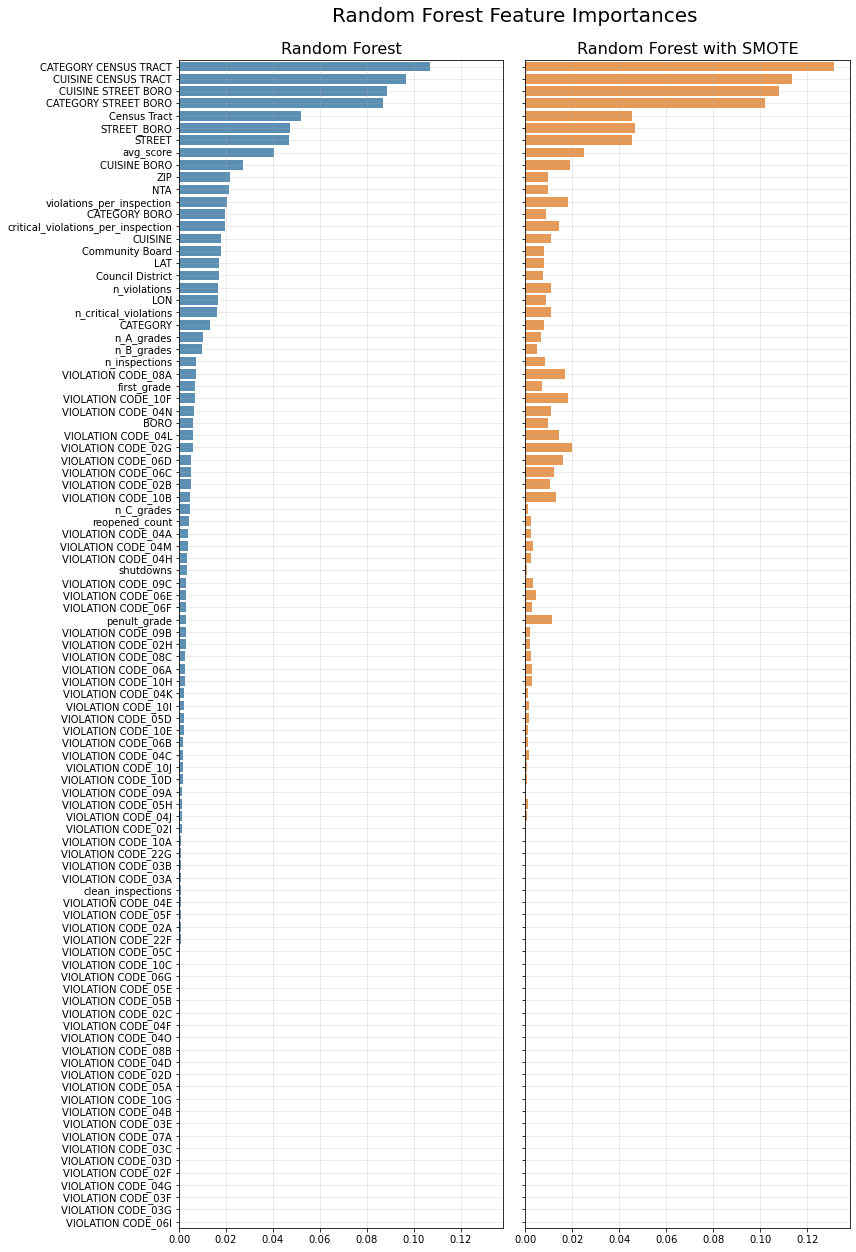

In [353]:
# Get feature importances for rf and rf_smote
importances_rf = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values()
importances_rf_smote = pd.Series(rf_smote.feature_importances_, index=X_test_smote.columns).sort_values()

# Plot as bars
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,17), sharex=True)
sns.barplot(
    data=importances_rf.reset_index().sort_values(by=0, ascending=False),
    x=0,
    y='index',
    ax=ax[0],
    color='tab:blue',
    alpha=0.8
)
sns.barplot(
    data=importances_rf_smote[importances_rf.sort_values(ascending=False).index].reset_index(),
    x=0,
    y='index',
    ax=ax[1],
    color='tab:orange',
    alpha=0.8
)
ax[0].set_title('Random Forest', fontsize=16)
ax[1].set_title('Random Forest with SMOTE', fontsize=16)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].set_yticklabels(['']*len([item.get_text() for item in ax[1].get_yticklabels()]))
plt.tight_layout()
plt.suptitle('Random Forest Feature Importances', y=1.02, x=0.6, fontsize=20)
plt.show()


#### ROC AUC Curves

Text(0.5, 1.0, 'ROC Curve: Random Forest Predicting B or C Inspection Grades')

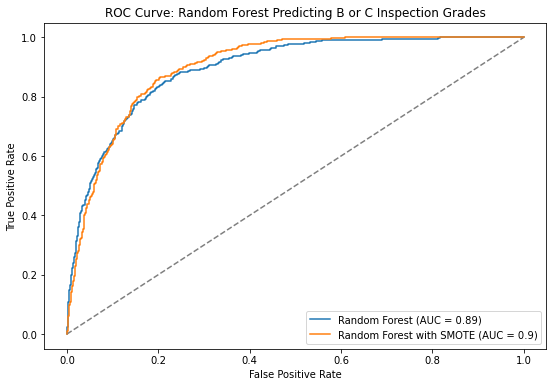

In [354]:
# Get predicted probabilites and calc roc curve for rf and rf_smote
y_pred_prob_sm = rf_smote.predict_proba(X_test_smote)[:,1]
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test_smote, y_pred_prob_sm, pos_label='B or C')
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='B or C')

# Plot
fig, ax = plt.subplots(figsize=(9,6))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.plot(fpr, tpr, label='Random Forest (AUC = ' + str(round(roc_auc_score(y_test, y_pred_prob),2)) + ')')
plt.plot(fpr_sm, tpr_sm, label='Random Forest with SMOTE (AUC = ' + str(round(roc_auc_score(y_test_smote, y_pred_prob_sm),2)) + ')')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Predicting B or C Inspection Grades')

#### Confusion Matrices

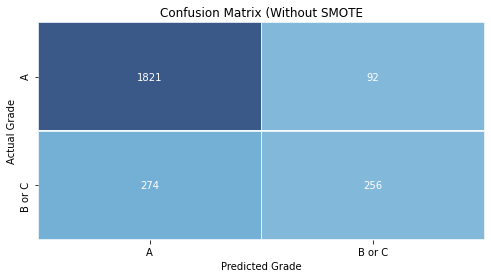

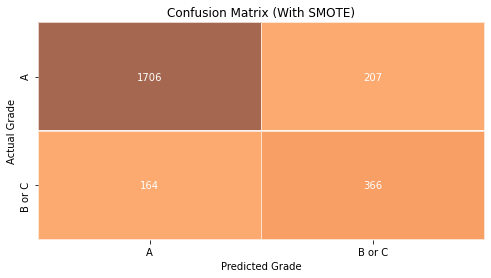

In [355]:
import matplotlib as mpl

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set up df and colors for heatmap
cm_df = pd.DataFrame(cm,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#Plot confusion matrix as heatmap
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.8)
plt.title('Confusion Matrix (Without SMOTE')
plt.ylabel('Actual Grade')
plt.xlabel('Predicted Grade')
plt.show()

### REPEAT WITH SMOTE

# Create a confusion matrix
cm_smote = confusion_matrix(y_test_smote, y_pred_smote)

# Set up df and colors for heatmap
cm_df_smote = pd.DataFrame(cm_smote,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Oranges(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

# Plot confusion matrix as heatmap
plt.figure(figsize=(8,4))
sns.heatmap(cm_df_smote, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.7)
plt.title('Confusion Matrix (With SMOTE)')
plt.ylabel('Actual Grade')
plt.xlabel('Predicted Grade')
plt.show()

### PART 4: Analysis & Conclusions

**Strengths:** Using Machine Learning, we can predict which restaurants will receive low grades on inspections at a rate 3x better than chance. At that level of precision, the City could identify about 70% of restaurants that might pose health & safety risks to customers and prioritize them for future inspections, outreach, oversight, assistance, or other interventions. 

**Limitations:** The City needs to inspect all restaurants anyways - the usefulness of flagging restaurants likely to receive low grades might be questionable. Arguably, DOHMH should dedicate more time and resources towards restaurants unlikely to receive A's to 1) achieve better health outcomes for residents, and 2) help restaurants improve conditions so they can stay in business. Another limitation is that inspectors' neutrality could be compromised if they knew a restaurant was flagged by an algorithm for being likely to receive a low grade. To avoid introducing bias into the inspection process, the City could either A) ensure inspectors remain blind to the model's predictions, or B) use predictions for restaurant outreach, assistance, and support - not for inspections. 

**Next Steps:** Predictions could be improved by incorporating other datasets. The City has troves of data from DOHMH and other departments which might increase the model's predictive power - perhaps to the point where B's & C's could be ungrouped and a model could predict each grade separately. Further, other Machine Learning algorithms could be tested. We only used a Random Forest, but there are many algorithms that could work well on such a classification problem. Individual models and Ensemble models, such as Voting Classifiers, might yield better results. 

## Appendix:

#### Predictions with Voting Classifier

**WITH SMOTE**

In [356]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

lr_sm = LogisticRegression()
lr_sm.fit(X_smote, y_smote)
lr_pred_sm = lr_sm.predict(X_test_smote)
# print(classification_report(y_test_smote, lr_pred_sm))

knn_sm = KNeighborsClassifier(n_neighbors=10)
knn_sm.fit(X_smote, y_smote)
knn_pred_sm = knn_sm.predict(X_test_smote)
# print(classification_report(y_test_smote, knn_pred_sm))

ab_sm = AdaBoostClassifier()
ab_sm.fit(X_smote, y_smote)
ab_pred_sm = ab.predict(X_test_smote)
# print(classification_report(y_test_smote, ab_pred_sm))

gb_sm = GradientBoostingClassifier()
gb_sm.fit(X_smote, y_smote)
gb_pred_sm = gb.predict(X_test_smote)
# print(classification_report(y_test_smote, gb_pred_sm))

vc_sm = VotingClassifier(estimators=[('lr',lr_sm), ('smote', rf_smote), ('knn',knn_sm), ('adaboost', ab_sm), ('gradientboost',gb_sm)], weights=[1,4,1,1,3], voting='soft')
vc_sm.fit(X_smote, y_smote)
vc_pred_sm = vc_sm.predict(X_test_smote)
print(classification_report(y_test_smote, vc_pred_sm))


              precision    recall  f1-score   support

           A       0.92      0.87      0.90      1913
      B or C       0.62      0.74      0.67       530

    accuracy                           0.84      2443
   macro avg       0.77      0.81      0.79      2443
weighted avg       0.86      0.84      0.85      2443



**WITHOUT SMOTE**

In [357]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
# print(classification_report(y_test, lr_pred))

knn = KNeighborsClassifier(n_neighbors=75)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
# print(classification_report(y_test, knn_pred))

ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_test)
# print(classification_report(y_test, ab_pred))

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
# print(classification_report(y_test, gb_pred))

vc = VotingClassifier(estimators=[('rf', rf), ('lr',lr), ('knn',knn), ('adaboost',ab), ('gradientboost',gb)], weights=[4,2,2,3,4], voting='soft')
vc.fit(X_train, y_train)
vc_pred = vc.predict(X_test)
print(classification_report(y_test, vc_pred))

              precision    recall  f1-score   support

           A       0.89      0.94      0.91      1913
      B or C       0.73      0.58      0.65       530

    accuracy                           0.86      2443
   macro avg       0.81      0.76      0.78      2443
weighted avg       0.85      0.86      0.86      2443



Text(0.5, 1.0, 'ROC Curve: Random Forest Predicting B or C Inspection Grades')

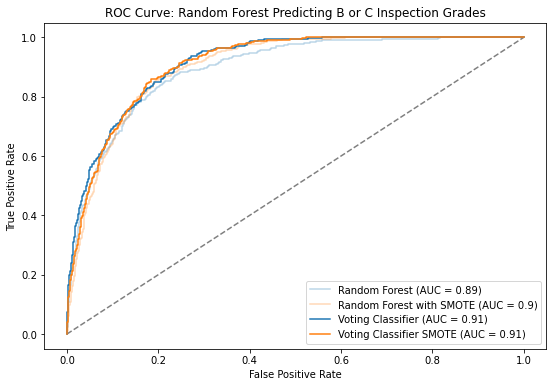

In [358]:
# Get predicted probabilites and calc roc curve for rf and rf_smote
y_pred_prob_sm = rf_smote.predict_proba(X_test_smote)[:,1]
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test_smote, y_pred_prob_sm, pos_label='B or C')
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='B or C')
y_pred_prob_vc = vc.predict_proba(X_test)[:,1]
fpr_vc, tpr_vc, thresholds_vc = roc_curve(y_test, y_pred_prob_vc, pos_label='B or C')
y_pred_prob_vc_sm = vc_sm.predict_proba(X_test_smote)[:,1]
fpr_vc_sm, tpr_vc_sm, thresholds_vc_sm = roc_curve(y_test_smote, y_pred_prob_vc_sm, pos_label='B or C')

# Plot
fig, ax = plt.subplots(figsize=(9,6))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.plot(fpr, tpr, alpha=0.3, label='Random Forest (AUC = ' + str(round(roc_auc_score(y_test, y_pred_prob),2)) + ')', color='tab:blue')
plt.plot(fpr_sm, tpr_sm, alpha=0.3, label='Random Forest with SMOTE (AUC = ' + str(round(roc_auc_score(y_test_smote, y_pred_prob_sm),2)) + ')', color='tab:orange')
plt.plot(fpr_vc, tpr_vc, label='Voting Classifier (AUC = ' + str(round(roc_auc_score(y_test, y_pred_prob_vc),2)) + ')', color='tab:blue')
plt.plot(fpr_vc_sm, tpr_vc_sm, label='Voting Classifier SMOTE (AUC = ' + str(round(roc_auc_score(y_test_smote, y_pred_prob_vc_sm),2)) + ')', color='tab:orange')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Predicting B or C Inspection Grades')